# ADAcadabras Milestone 2

***Notebook containing main methods used to deal with the raw data, process it, and extract the main figures which will let us conduct our analysis.***

## General Information

As you will see, this notebook only loads and analyses the data from year 2020, considering it as the smallest dataset. Running the notebook as a TA for all years would constitute a large chunk of time, which is why the notebook will only address 2020.

***Libraries used:***
- python=3.8.12
- pandas
- datetime
- time
- matplotlib
- seaborn
- scipy
- pickle
- bz2
- json

***Files and directories to make this notebook run successfully:***

- **data/**
  - **parquet/**
    - *speaker_attributes.parquet*
    - *wikidata_labels_descriptions_quotebank.csv.bz2*
  - **filtered/**
    - **pickles/**
      - *quotes-2020-filtered.pkl.bz2*
    - *quotes-2020-filtered.json.bz2*
  - *quotes-2020.json.bz2*
- *data_processing.ipynb*
- *helper.py*



Directories are in **bold** and files are in *italic*


---

# After imports, go run this [cell](#per_gender) for load **gender** data of metoo


# IMPORTS

In [1]:
import bz2
import json
import pickle as pkl
from time import time
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

import helper

# PATH

In [2]:
# Part 3)
PATH_DATA = './../data/'
path_quotebank = PATH_DATA + 'quotes-{}.json.bz2' + '............NO MORE IN LOCAL DATA...................'
# need PATH_DATA_GENDER also

# Part 1)
path_quote_women = PATH_DATA + 'Quotebank/quotes-{}-filtered.json.bz2'
path_pkl_women = PATH_DATA + 'Quotebank/pickles/quotes-{}-filtered.pkl'
path_quote_women_monthly = PATH_DATA + 'Quotebank/quotes-{}-filtered/{}' # completed in function as it depend on month

path_quote_metoo = PATH_DATA + 'Quotebank/metoo/quotes-{}-filtered_metoo.json.bz2'
path_quote_metoo_monthly = PATH_DATA + 'Quotebank/metoo/quotes-{}-filtered_metoo/{}' # completed in function as it depend on month

# Part 2)
PATH_PARQUET = PATH_DATA + 'parquet/'
PARQUET_FILE = PATH_PARQUET + 'speaker_attributes.parquet'
WIKIDATA_LABELS_FILE = PATH_PARQUET + 'wikidata_labels_descriptions_quotebank.csv.bz2'
PATH_DATA_GENDER = PATH_DATA + 'Quotebank/genders.json.bz2'

---

# Part 1 ) Create subset D2 and D3 from Quotebank (raw)

***Creating datasets D3 and D2 and storing them for later use (Part 3)***

In the README, we have mentioned in the **Methods** paragraph that there will be subsets to D2 and D3. In this notebook, we will only create D3. 
This is because D2 is in fact a subset of D3 (see `helper.py` for the definition of our keywords). The rest of the datasets will be derived from D3 for milestone 3.

## D3

In [ ]:
from helper import keywords
years = range(2015, 2020+1)

for year in years:
    src_path = path_quotebank.format(year)
    dst_path = path_quote_women.format(year)
    helper.generate_data_keyword(src_path, dst_path, keywords)

In [ ]:
# create pickles
for year in years:
    src_path = path_quote_women.format(year)
    dst_path = path_pkl_women.format(year)
    helper.generate_pickles(dst_path, pkl_path, CHUNK_SIZE)

In [ ]:
# create monthly dataset
for year in years:
    src_path = path_quote_women.format(year)
    dst_path = path_quote_women_monthly.format(year, year) + '_{}.json.bz2'
    helper.generate_data_monthly(src_path, dst_path, keywords)

## D2

In [4]:
from helper import people_dict, metoo_dict, action_dict
keywords_metoo = people_dict\
          .union(metoo_dict)\
          .union(action_dict)
years = range(2015, 2020+1)

for year in years:
    src_path = path_quote_women.format(year)
    dst_path = path_quote_metoo.format(year)
    helper.generate_data_keyword(src_path, dst_path, keywords_metoo)

In [29]:
# create monthly dataset
for year in years:
    src_path = path_quote_metoo.format(year)
    dst_path = path_quote_metoo_monthly.format(year, year) + '_{}_metoo.json.bz2'
    helper.generate_data_monthly(src_path, dst_path, keywords)

year 2015 have been procesed in 233.48346972465515 [s]
year 2016 have been procesed in 156.41457176208496 [s]
year 2017 have been procesed in 362.4314079284668 [s]
year 2018 have been procesed in 379.03695702552795 [s]
year 2019 have been procesed in 261.2811245918274 [s]
year 2020 have been procesed in 64.24079704284668 [s]
full data have been processed in 1456.889312028885 [s]


---
# Part 2 ) analyse Parquet File

***Load Speaker's Metadata from the parquet file***

In [3]:
%%time
df_parquet = pd.read_parquet(PARQUET_FILE)
# | aliases | date_of_bitrh | nationality | gender | lastrevid | ethnic_group | US_congress_bio_ID | occupation | party | academic_degree | id | label | candidacy | type | religion |
df_parquet.head()

CPU times: user 18 s, sys: 3.42 s, total: 21.5 s
Wall time: 16.6 s


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


In [4]:
print(f'Parquet file shape: {df_parquet.shape}',
      f'Are ids unique?   : {df_parquet.id.nunique()==df_parquet.shape[0]}',
      f'{"-"*30}',
      'Count:',
      df_parquet.count(), sep='\n')

Parquet file shape: (9055981, 15)
Are ids unique?   : True
------------------------------
Count:
aliases               1203402
date_of_birth         5017333
nationality           3715852
gender                7105600
lastrevid             9055981
ethnic_group           130385
US_congress_bio_ID      12874
occupation            6373084
party                  399176
academic_degree         99995
id                    9055981
label                 8543681
candidacy               65442
type                  9055981
religion               196284
dtype: int64


**NOTE:** The counts above are differents because for a given QID, there might not exist every metadata possible (*e.g.* an author might not belong to a political party)

---

***Load the QID's of present instances in Quotebank*** 

It contains QID's of speakers, their gender, nationality and others if present. 

In [4]:
%%time
df_qid = pd.read_csv(WIKIDATA_LABELS_FILE, compression='bz2')
# | QID | Label | Description |

CPU times: user 206 ms, sys: 50.2 ms, total: 256 ms
Wall time: 211 ms


In [6]:
print(df_qid.describe().loc[['count', 'unique']])
df_qid.sample(4)

          QID  Label Description
count   36969  32951       24542
unique  36969  31462       17029


,QID,Label,Description
35918,Q28753610,Municipal elections 2012 in Utsjoki in Finland,Municipal elections in 2012 in Utsjoki in Finland
3570,Q28752932,Municipal elections 2012 in Akaa in Finland,Municipal elections in 2012 in Akaa in Finland
855,Q743335,Chief Minister of Montserrat,former public post in Montserrat (1960–2010); ...
29317,Q2397385,podporuchik,officer's rank out of the lieutenants rank gro...


We notice that QID's are unique as expected, but not labels and descriptions which can also be non-defined (*i.e.* NaN)

---

***Defining different useful dataframes for our analysis***

In [5]:
df_gender = helper.gender_in_parquet(df_parquet, df_qid)
df_gender

,gender_qids,speaker_qids,description
gender_names,,,
--> Not repertiored [1] ???,Q15145782,Q78971059,-
--> Not repertiored [2] ???,Q15145783,Q2078379,-
Erkek,Q106299064,Q106375776,family name
Gorō,Q8964773,Q1515301,male given name
Taira no Kiyomori,Q281833,Q710537,Japanese samurai (1118-1181)
X-gender,Q96000630,Q2336456,a third gender or non-binary gender identity t...
agender,Q505371,Q4754807,absence of a gender identity
androgyny,Q207959,Q66283650,combination of male and female traits
assigned female at birth,Q99485785,Q492190,gender identity assigned at birth


In [8]:
# gender repertoriered > it exists in metadata
df_parquet[df_parquet.id == 'Q78971059']

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3040274,"[Anne P. O'Brien, Anne O'Brien]",[+1954-00-00T00:00:00Z],[Q408],"[Q6581072, Q15145782]",1395620619,None,None,"[Q201788, Q1622272, Q482980]",None,None,Q78971059,Anne Philomena O'Brien,None,item,None


In [9]:
# but not labeled: empty output
df_qid[df_qid.QID == 'Q15145782']

,QID,Label,Description


Hand searching: [Q15145782](https://www.wikidata.org/wiki/Q15145782)'s label is also *transgender female*, which is a redirection to the labaled [Q1052281](https://www.wikidata.org/wiki/Q1052281) qid

<a id='error2'></a>
**NOTE:** We can notice some irregularities in the data: some QID's considered as genders are not really genders.
- **Queer, homosexuality:** Sexual orientation
- **Erkek, Gorō:** Family Names
- **Taira no Kiyomori:** Japanese Samurai
- **Male/female organism:** Not really an irregularity but since speakers are human, it should not exist as a gender in the database

There are also two QID's that correspond to transgender male/female when searching manually for them online, but they are not classified as such in the given wikidata file. A cause of this might be the fact that there already exists a QID for transgender males/females. Therefore, we will not drop them.

In [6]:
# Write result in json file
df_gender.reset_index().to_json(PATH_DATA_GENDER, orient='records', lines=True)  # need to reset index because previous index was string... lost when write

---

# Part 3) Create Dataset - mix Parquet/Quotebank

***This is the main code for analysing a given year of Quotebank***

We will count the number of quotations classified per gender and in time (per week)

### read dataframes from part 2

In [3]:
### --> not needto run if part 2) was ran
# read Parquet and gender
df_parquet = pd.read_parquet(PARQUET_FILE)
# read Gender fom parquet analysis
df_gender = pd.read_json(PATH_DATA_GENDER, orient='records', lines=True)
df_gender.set_index('gender_names', inplace=True)

### create list and dataframe to create Datasets

In [4]:
# list of Genders qid
wrong_genders = ['Erkek', 'Gorō', 'Taira no Kiyomori', 'queer', 'homosexuality']
qid_male    = [df_gender.loc['male'].gender_qids]
qid_female  = [df_gender.loc['female'].gender_qids]
qids_others = df_gender.drop(['male', 'female'] + wrong_genders)[['gender_qids']].gender_qids
qids_wrong  = df_gender.loc[wrong_genders].gender_qids

# Create dataframe to record weekly quotations per genders
col_weekly    = ['male', 'female', 'others','wrong', 'none', 'speaker_noParquet', 'speaker_None', 'all']
idx_weekly    = [i for i in range(1, 54)] # Represents 53 weeks (52 full + last incomplete, which is the 1st week of the following year)
df_weekly_count = pd.DataFrame(0, index=idx_weekly, columns=col_weekly)

# column to mix between Parquet and Quotebank
quote_column = ['quoteID','quotation','speaker','qids','date']
parquet_column = ['date_of_birth', 'gender', 'party', 'id']
df_selected_parquet = df_parquet[parquet_column]

### create Dataset

q_male, q_female, q_others, q_wrong, q_None, q_speaker_noParquet, q_noSpeaker = helper.split_quotes_per_gender(chunk, df_selected_parquet, qid_male, qid_female, qids_others, qids_wrong, df_weekly_count)

#### Monthly Male quotes from D3 (women) - 2020 only

In [16]:
data_path = path_quote_women.format(2020)
CHUNK_SIZE = 1e5
reader = pd.read_json(path_to_quotes, lines=True, compression='bz2', chunksize=CHUNK_SIZE)

for chunk in reader:
    chunk = chunk.filter(items=quote_column)
    q_male, q_female, q_others, q_wrong, q_None, q_speaker_noParquet, q_noSpeaker = \
    helper.split_quotes_per_gender(chunk, df_selected_parquet, qid_male, qid_female, qids_others, qids_wrong, df_weekly_count)
    
    # write a file for each month
    for month in q_male.month.unique():
        chunk_month = q_male[q_male.month==month]
        path_per_month = f'./../data/Quotebank/male_{month}.json.bz2'
        with bz2.open(path_per_month, 'ab') as month_file:
            chunk_month.to_json(path_per_month, orient='records', lines=True)

#### Male/Female/Other quotes from D2 (metoo)

In [7]:
years = range(2015, 2020+1)
CHUNK_SIZE = 1e5
for year in years:
    data_path = path_quote_metoo.format(year)
    reader = pd.read_json(data_path, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
    i = 0
    for chunk in reader:
        chunk = chunk.filter(items=quote_column)
        q_male, q_female, q_others, _, _, _, _ = \
        helper.split_quotes_per_gender(chunk, df_selected_parquet, qid_male, qid_female, qids_others, qids_wrong, df_weekly_count)

        # record Male
        path_male = PATH_DATA + f'Quotebank/metoo/quotes-{year}-filtered_metoo/{year}_male.json.bz2'
        with bz2.open(path_male, 'ab') as male_file:
            q_male.to_json(male_file, orient='records', lines=True)
        
        # record Female
        path_female = PATH_DATA + f'Quotebank/metoo/quotes-{year}-filtered_metoo/{year}_female.json.bz2'
        with bz2.open(path_female, 'ab') as female_file:
            q_female.to_json(female_file, orient='records', lines=True)
            
        # record Others
        path_others = PATH_DATA + f'Quotebank/metoo/quotes-{year}-filtered_metoo/{year}_others.json.bz2'
        with bz2.open(path_others, 'ab') as others_file:
            q_others.to_json(others_file, orient='records', lines=True)
        print(f"chunk {i+1} process")
        i += 1
    print(f"--> year {year} processed\n")

chunk 1 process
chunk 2 process
--> year 2015 processed

chunk 1 process
--> year 2016 processed

chunk 1 process
chunk 2 process
--> year 2017 processed

chunk 1 process
chunk 2 process
--> year 2018 processed

chunk 1 process
chunk 2 process
--> year 2019 processed

chunk 1 process
--> year 2020 processed



#### count weekly quotes per gender for D3 and D2

In [54]:
years = range(2015, 2020+1)
CHUNK_SIZE = 1e5

data_paths = [path_quote_women, path_quote_metoo]
begin_total = time()
for path in data_paths:
    for year in years:
        begin_year = time()
        data_path = path.format(year)
        print("processing path:", data_path[19:])
        df_weekly_count = pd.DataFrame(0, index=idx_weekly, columns=col_weekly)
        reader = pd.read_json(data_path, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
        i = 0
        for chunk in reader:
            begin_chunk = time()
            chunk = chunk.filter(items=quote_column)

            helper.split_quotes_per_gender(chunk, df_selected_parquet, qid_male, qid_female, qids_others, qids_wrong, df_weekly_count)
            print(f"\tchunk {i+1} done in {(time()-begin_chunk):.1f} [s]")
            i += 1
        
        # record count
        df_weekly_count.loc['sum'] = df_weekly_count.sum()
        df_weekly_count = df_weekly_count.astype(int)
        df_weekly_count.reset_index(inplace=True) # Json format do not like str index (last one is 'sum')
        df_weekly_count.rename(columns = {'index':'week'}, inplace = True)
        new_file_path = data_path[:-9] + '_weekly_count' + data_path[-9:]
        with bz2.open(new_file_path, 'wb') as file: ## Need to delete existing file is open in "Append" mode
            df_weekly_count.to_json(file, orient='records', lines=True)
        print(f"\t--> year {year} done in {(time()-begin_year):.1f} [s]\n")
print(f'datasets created in {(time() - begin_total):.1f} [s]')

processing path: /quotes-2015-filtered.json.bz2
	chunk 1 done in 7.2 [s]
	chunk 2 done in 7.2 [s]
	chunk 3 done in 7.2 [s]
	chunk 4 done in 7.2 [s]
	chunk 5 done in 7.2 [s]
	chunk 6 done in 7.2 [s]
	chunk 7 done in 7.2 [s]
	chunk 8 done in 7.2 [s]
	chunk 9 done in 7.1 [s]
	chunk 10 done in 7.2 [s]
	chunk 11 done in 7.2 [s]
	chunk 12 done in 7.2 [s]
	chunk 13 done in 7.2 [s]
	chunk 14 done in 7.0 [s]
	--> year 2015 done in 168.8 [s]

processing path: /quotes-2016-filtered.json.bz2
	chunk 1 done in 7.2 [s]
	chunk 2 done in 7.3 [s]
	chunk 3 done in 7.2 [s]
	chunk 4 done in 7.2 [s]
	chunk 5 done in 7.3 [s]
	chunk 6 done in 7.3 [s]
	chunk 7 done in 7.2 [s]
	chunk 8 done in 7.3 [s]
	chunk 9 done in 7.2 [s]
	chunk 10 done in 7.0 [s]
	--> year 2016 done in 127.5 [s]

processing path: /quotes-2017-filtered.json.bz2
	chunk 1 done in 7.3 [s]
	chunk 2 done in 7.2 [s]
	chunk 3 done in 7.2 [s]
	chunk 4 done in 7.2 [s]
	chunk 5 done in 7.3 [s]
	chunk 6 done in 7.3 [s]
	chunk 7 done in 8.3 [s]
	chunk 

#### create sentiment/age for (D2)metoo and (D3)women

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/pkr/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
sia = SentimentIntensityAnalyzer()
age_limite1 = 40
age_limite2 = 60
compound_limite = 0.05

years = range(2015, 2020+1)
CHUNK_SIZE = 1e5

data_paths = [path_quote_women, path_quote_metoo]
begin_total = time()
for path in data_paths:
    for year in years:
        begin_year = time()
        data_path = path.format(year)
        print("processing path:", data_path[19:])
        reader = pd.read_json(data_path, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
        i = 0
        for chunk in reader:
            begin_chunk = time()
            chunk = chunk.filter(items=quote_column)

            # remove unknown speaker
            q_is_speaker_None = chunk.speaker=='None' # Checker auusi pou les NaN -> isna()
            q_speaker         = chunk[-q_is_speaker_None].copy()
            q_speaker['qid'] = q_speaker.qids.apply(lambda x: x[0]) # 1st homonym
            q_speaker = q_speaker.drop(columns=['qids'])
            q_speaker = q_speaker.merge(df_selected_parquet, left_on='qid', right_on='id', how='left')

            # age
            q_is_speaker_DOB = q_speaker.date_of_birth.notna()
            q_speaker        = q_speaker[q_is_speaker_DOB]
            q_speaker['age']     = q_speaker.date_of_birth.apply(lambda x: year - int(x[0][1:5])) # we consider speaker is born the 01/01/XXXX - and article of year YYYY have been published the 01/01/YYYY
            q_speaker['age_cat'] = q_speaker.age.apply(lambda x: '0_40' if x <= age_limite1 else '41_60' if x <= age_limite2 else '61_inf')

            # sentiment
            q_speaker['compound']  = q_speaker.quotation.apply(lambda x: sia.polarity_scores(x)['compound'])
            q_speaker['sentiment'] = q_speaker.compound.apply(lambda x: 'neg' if x <= -compound_limite else 'neu' if x <= compound_limite else 'pos')
            
            # drop unused column
            q_speaker.drop(columns=['date_of_birth','id'], inplace=True)
            
            # record result
            new_file_path = data_path[:-9] + '_sentiment_age' + data_path[-9:]
            with bz2.open(new_file_path, 'ab') as file: ## Need to delete existing file as open in "Append" mode   --> !!! !!! !!! <--
                q_speaker.to_json(file, orient='records', lines=True)
            print(f"\tchunk {i+1} done in {(time()-begin_chunk):.1f} [s]")
            i += 1
        print(f"\t--> year {year} done in {(time()-begin_year):.1f} [s]\n")
print(f'datasets created in {(time() - begin_total):.1f} [s]')

processing path: /quotes-2015-filtered.json.bz2
	chunk 1 done in 24.8 [s]
	chunk 2 done in 25.1 [s]
	chunk 3 done in 25.2 [s]
	chunk 4 done in 25.1 [s]
	chunk 5 done in 25.0 [s]
	chunk 6 done in 25.3 [s]
	chunk 7 done in 25.0 [s]
	chunk 8 done in 25.1 [s]
	chunk 9 done in 25.2 [s]
	chunk 10 done in 25.1 [s]
	chunk 11 done in 25.0 [s]
	chunk 12 done in 25.2 [s]
	chunk 13 done in 25.1 [s]
	chunk 14 done in 20.3 [s]
	--> year 2015 done in 419.5 [s]

processing path: /quotes-2016-filtered.json.bz2
	chunk 1 done in 24.8 [s]
	chunk 2 done in 24.9 [s]
	chunk 3 done in 24.9 [s]
	chunk 4 done in 25.0 [s]
	chunk 5 done in 24.9 [s]
	chunk 6 done in 24.8 [s]
	chunk 7 done in 24.9 [s]
	chunk 8 done in 25.1 [s]
	chunk 9 done in 24.8 [s]
	chunk 10 done in 19.1 [s]
	--> year 2016 done in 295.1 [s]

processing path: /quotes-2017-filtered.json.bz2
	chunk 1 done in 24.9 [s]
	chunk 2 done in 24.9 [s]
	chunk 3 done in 25.2 [s]
	chunk 4 done in 25.1 [s]
	chunk 5 done in 24.9 [s]
	chunk 6 done in 24.8 [s]
	c

<a id=per_gender>

#### compound per gender

In [13]:
years = range(2015, 2020+1)
CHUNK_SIZE = 1e5

data_paths = [path_quote_women, path_quote_metoo]
begin_total = time()
for path in data_paths:
    for year in years:
        begin_year = time()
        data_path = path.format(year)
        data_path = data_path[:-9] + '_sentiment_age' + data_path[-9:]
        print("processing path:", data_path[19:])
        reader = pd.read_json(data_path, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
        i = 0
        for chunk in reader:
            begin_chunk = time()

            chunk_is_gender = chunk.gender.notna()
            chunk = chunk[chunk_is_gender]
            chunk['gender'] = chunk.gender.apply(lambda x: x[0])
            q_male_female   = chunk[chunk.gender.isin(qid_male+qid_female)].copy()
            q_male_female.gender.replace([qid_male[0], qid_female[0]],['male','female'], inplace=True)
            
            # general : count and avg compound per gender per age cat
            male_female_mean = q_male_female[['gender', 'age_cat', 'compound']].groupby(['gender','age_cat']).agg({'sum', 'count', 'std'})
            male_female_mean = male_female_mean.droplevel(0, axis=1) # drop "compounds" primary index
            # to compute the average std later (pooled variation)
            male_female_mean['std'] = male_female_mean['std']*male_female_mean['count']
            
            # detailed : count and agv compound per gender per age cat per sentiment
            male_female = q_male_female[['gender', 'age_cat','sentiment', 'compound']].groupby(['sentiment','age_cat','gender']).agg({'sum', 'count', 'std'})
            male_female = male_female.droplevel(0, axis=1) # drop "compounds" primary index
            # to compute the average std later (pooled variation)
            male_female['std'] = male_female['std']*male_female['count']
            
            if i==0:
                df_compound_count_detail = male_female.copy()
                df_compound_count_general= male_female_mean.copy()
            else:
                df_compound_count_detail = df_compound_count_detail.add(male_female, fill_value=0)
                df_compound_count_general = df_compound_count_general.add(male_female_mean, fill_value=0)
            print(f"\tchunk {i+1} done in {(time()-begin_chunk):.1f} [s]")
            i += 1
        
        # general
        df_compound_count_general['mean'] = df_compound_count_general['sum']/df_compound_count_general['count']
        df_compound_count_general['std']  = df_compound_count_general['std']/df_compound_count_general['count']
        df_compound_count_general.drop(columns=['sum'], inplace=True)
        new_file_path_general = data_path[:-9] + '_compounds_per_gender_age' + data_path[-9:]
        with bz2.open(new_file_path_general, 'wb') as file:
            df_compound_count_general.reset_index().to_json(file, orient='records', lines=True)
                
        # detailed
        df_compound_count_detail['mean'] = df_compound_count_detail['sum']/df_compound_count_detail['count']
        df_compound_count_detail['std']  = df_compound_count_detail['std']/df_compound_count_detail['count']
        df_compound_count_detail.drop(columns=['sum'], inplace=True)
        new_file_path_detail = data_path[:-9] + '_compounds_per_gender_age_sentiment' + data_path[-9:]
        with bz2.open(new_file_path_detail, 'wb') as file:
            df_compound_count_detail.reset_index().to_json(file, orient='records', lines=True)
        
        print(f"\t--> year {year} done in {(time()-begin_year):.1f} [s]\n")
print(f'datasets created in {(time() - begin_total):.1f} [s]')

processing path: /quotes-2015-filtered_sentiment_age.json.bz2
	chunk 1 done in 0.3 [s]
	chunk 2 done in 0.3 [s]
	chunk 3 done in 0.3 [s]
	chunk 4 done in 0.3 [s]
	chunk 5 done in 0.3 [s]
	chunk 6 done in 0.3 [s]
	chunk 7 done in 0.3 [s]
	chunk 8 done in 0.1 [s]
	--> year 2015 done in 24.4 [s]

processing path: /quotes-2016-filtered_sentiment_age.json.bz2
	chunk 1 done in 0.3 [s]
	chunk 2 done in 0.3 [s]
	chunk 3 done in 0.3 [s]
	chunk 4 done in 0.3 [s]
	chunk 5 done in 0.3 [s]
	chunk 6 done in 0.1 [s]
	--> year 2016 done in 16.1 [s]

processing path: /quotes-2017-filtered_sentiment_age.json.bz2
	chunk 1 done in 0.3 [s]
	chunk 2 done in 0.3 [s]
	chunk 3 done in 0.3 [s]
	chunk 4 done in 0.3 [s]
	chunk 5 done in 0.3 [s]
	chunk 6 done in 0.3 [s]
	chunk 7 done in 0.3 [s]
	chunk 8 done in 0.3 [s]
	chunk 9 done in 0.3 [s]
	chunk 10 done in 0.2 [s]
	--> year 2017 done in 30.3 [s]

processing path: /quotes-2018-filtered_sentiment_age.json.bz2
	chunk 1 done in 0.3 [s]
	chunk 2 done in 0.3 [s]
	c

In [18]:
year = 2020
data_path = path_quote_women.format(year)
data_path = data_path[:-9] + '_sentiment_age' + data_path[-9:]
a = pd.read_json(data_path[:-9] + '_compounds_per_gender_age' + data_path[-9:], lines=True)
b = pd.read_json(data_path[:-9] + '_compounds_per_gender_age_sentiment' + data_path[-9:], lines=True)
a,b

(   gender age_cat       std  count      mean
 0  female    0_40  0.516178  33265  0.291742
 1  female   41_60  0.527431  28339  0.222637
 2  female  61_inf  0.519412  18289  0.169506
 3    male    0_40  0.526284  25342  0.244543
 4    male   41_60  0.530386  40448  0.207514
 5    male  61_inf  0.528371  42497  0.172241,
    sentiment age_cat  gender       std  count      mean
 0        neg    0_40  female  0.250317   6943 -0.489454
 1        neg    0_40    male  0.249500   6001 -0.498545
 2        neg   41_60  female  0.250106   7082 -0.500764
 3        neg   41_60    male  0.255847  10471 -0.504614
 4        neg  61_inf  female  0.249271   4900 -0.510200
 5        neg  61_inf    male  0.252957  11766 -0.508368
 6        neu    0_40  female  0.008016   5702  0.000178
 7        neu    0_40    male  0.007096   4588  0.000234
 8        neu   41_60  female  0.007550   5198  0.000357
 9        neu   41_60    male  0.007552   7466  0.000110
 10       neu  61_inf  female  0.006552   3835  0.

#### compoundf for specific week

In [17]:
import datetime

years = range(2015, 2020+1)
CHUNK_SIZE = 1e5

dates=[(8,3), (15,10)]

data_paths = [path_quote_women, path_quote_metoo]
begin_total = time()
for path in data_paths:
    for year in years:
        for date in dates:
            begin_year = time()
            day = date[0]
            month = date[1]
            data_path = path.format(year)
            data_path = data_path[:-9] + '_sentiment_age' + data_path[-9:]
            print("processing path:", data_path[19:])
            reader = pd.read_json(data_path, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
            i = 0
            for chunk in reader:
                begin_chunk = time()

                chunk_is_gender = chunk.gender.notna()
                chunk = chunk[chunk_is_gender]
                chunk['gender'] = chunk.gender.apply(lambda x: x[0])
                q_male_female   = chunk[chunk.gender.isin(qid_male+qid_female)].copy()
                q_male_female.gender.replace([qid_male[0], qid_female[0]],['male','female'], inplace=True)

                date_event_begin = datetime.datetime(year, month, day)
                date_event1_end = datetime.datetime(year, month, day+4)
                is_consider = (q_male_female.date>=date_event_begin) & (q_male_female.date<=date_event1_end)
                q_male_female = q_male_female[is_consider]

                # general : count and avg compound per gender per age cat
                male_female_mean = q_male_female[['gender', 'age_cat', 'compound']].groupby(['gender','age_cat']).agg({'sum', 'count', 'std'})
                male_female_mean = male_female_mean.droplevel(0, axis=1)
                male_female_mean['std'] = male_female_mean['std']*male_female_mean['count']
                
                
                # detailed : count and agv compound per gender per age cat per sentiment
                male_female = q_male_female[['gender', 'age_cat','sentiment', 'compound']].groupby(['sentiment','age_cat','gender']).agg({'sum', 'count', 'std'})
                male_female = male_female.droplevel(0, axis=1)
                male_female['std'] = male_female['std']*male_female['count']
                

                if i==0:
                    df_compound_count_detail = male_female.copy()
                    df_compound_count_general= male_female_mean.copy()
                else:
                    df_compound_count_detail = df_compound_count_detail.add(male_female, fill_value=0)
                    df_compound_count_general = df_compound_count_general.add(male_female_mean, fill_value=0)
                print(f"\tchunk {i+1} done in {(time()-begin_chunk):.1f} [s]")
                i += 1

            # general : count and avg compound per gender per age cat
            df_compound_count_general['mean'] = df_compound_count_general['sum']/df_compound_count_general['count']
            df_compound_count_general['std']  = df_compound_count_general['std']/df_compound_count_general['count']
            df_compound_count_general.drop(columns=['sum'], inplace=True)
            new_file_path_general = data_path[:-9] + f'_compounds_per_gender_age_{day}_{month}' + data_path[-9:]
            with bz2.open(new_file_path_general, 'wb') as file:
                df_compound_count_general.reset_index().to_json(file, orient='records', lines=True)

            # detailed
            df_compound_count_detail['mean'] = df_compound_count_detail['sum']/df_compound_count_detail['count']
            df_compound_count_detail['std']  = df_compound_count_detail['std']/df_compound_count_detail['count']
            df_compound_count_detail.drop(columns=['sum'], inplace=True)
            new_file_path_detail = data_path[:-9] + f'_compounds_per_gender_age_sentiment_{day}_{month}' + data_path[-9:]
            with bz2.open(new_file_path_detail, 'wb') as file:
                df_compound_count_detail.reset_index().to_json(file, orient='records', lines=True)
        
        print(f"\t--> year {year} done in {(time()-begin_year):.1f} [s]\n")
print(f'datasets created in {(time() - begin_total):.1f} [s]')

processing path: /quotes-2015-filtered_sentiment_age.json.bz2
	chunk 1 done in 0.6 [s]
	chunk 2 done in 0.2 [s]
	chunk 3 done in 0.4 [s]
	chunk 4 done in 0.2 [s]
	chunk 5 done in 0.2 [s]
	chunk 6 done in 0.2 [s]
	chunk 7 done in 0.2 [s]
	chunk 8 done in 0.1 [s]
processing path: /quotes-2015-filtered_sentiment_age.json.bz2
	chunk 1 done in 0.2 [s]
	chunk 2 done in 0.2 [s]
	chunk 3 done in 0.2 [s]
	chunk 4 done in 0.2 [s]
	chunk 5 done in 0.2 [s]
	chunk 6 done in 0.2 [s]
	chunk 7 done in 0.2 [s]
	chunk 8 done in 0.1 [s]
	--> year 2015 done in 21.6 [s]

processing path: /quotes-2016-filtered_sentiment_age.json.bz2
	chunk 1 done in 0.2 [s]
	chunk 2 done in 0.2 [s]
	chunk 3 done in 0.2 [s]
	chunk 4 done in 0.2 [s]
	chunk 5 done in 0.2 [s]
	chunk 6 done in 0.1 [s]
processing path: /quotes-2016-filtered_sentiment_age.json.bz2
	chunk 1 done in 0.2 [s]
	chunk 2 done in 0.2 [s]
	chunk 3 done in 0.2 [s]
	chunk 4 done in 0.2 [s]
	chunk 5 done in 0.2 [s]
	chunk 6 done in 0.1 [s]
	--> year 2016 done

In [26]:
year = 2015
data_path = path_quote_women.format(year)
data_path = data_path[:-9] + '_sentiment_age' + data_path[-9:]
a = pd.read_json(data_path[:-9] + '_compounds_per_gender_age_8_3' + data_path[-9:], lines=True)
b = pd.read_json(data_path[:-9] + '_compounds_per_gender_age_sentiment_8_3' + data_path[-9:], lines=True)
a,b

(   gender age_cat       std  count      mean
 0  female    0_40  0.508436   1550  0.247813
 1  female   41_60  0.528299   1446  0.174091
 2  female  61_inf  0.513701    904  0.146341
 3    male    0_40  0.501313   1399  0.220921
 4    male   41_60  0.517701   2277  0.169012
 5    male  61_inf  0.504035   1838  0.180751,
    sentiment age_cat  gender       std  count      mean
 0        neg    0_40  female  0.250365    363 -0.457775
 1        neg    0_40    male  0.248389    315 -0.486249
 2        neg   41_60  female  0.247550    397 -0.513107
 3        neg   41_60    male  0.254202    625 -0.496167
 4        neg  61_inf  female  0.240281    244 -0.512108
 5        neg  61_inf    male  0.252693    469 -0.486117
 6        neu    0_40  female  0.006420    299 -0.000774
 7        neu    0_40    male  0.005568    314 -0.000457
 8        neu   41_60  female  0.006659    293  0.000180
 9        neu   41_60    male  0.007843    461  0.000307
 10       neu  61_inf  female  0.006200    225 -0.

In [27]:
import seaborn as sns
c = a.set_index(['gender', 'age_cat'])
c

std  count      mean
gender age_cat                           
female 0_40     0.508436   1550  0.247813
       41_60    0.528299   1446  0.174091
       61_inf   0.513701    904  0.146341
male   0_40     0.501313   1399  0.220921
       41_60    0.517701   2277  0.169012
       61_inf   0.504035   1838  0.180751

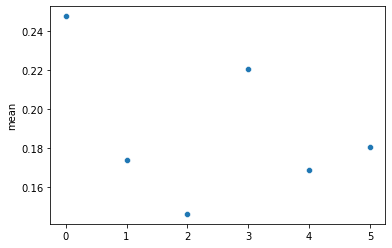

In [28]:
sns.scatterplot(x=a.index, y=a['mean'])
sns.scatterplot()

### weekly graph

In [56]:
data_path = path_quote_metoo
data_path = data_path[:-9] + '_weekly_count' + data_path[-9:]
path = data_path.format(2020)
count = pd.read_json(path, lines=True)
count

,week,male,female,others,wrong,none,speaker_noParquet,speaker_None,all
0,1,343,186,14,0,8,1,397,949
1,2,609,506,14,0,21,5,987,2142
2,3,824,519,12,0,9,6,1137,2507
3,4,674,558,16,0,17,8,1035,2308
4,5,698,527,12,0,8,16,1102,2363
5,6,790,688,9,0,20,6,1122,2635
6,7,886,597,11,0,9,9,1103,2615
7,8,754,479,12,0,18,7,1006,2276
8,9,648,563,24,0,14,1,1050,2300
9,10,554,605,7,0,9,9,771,1955


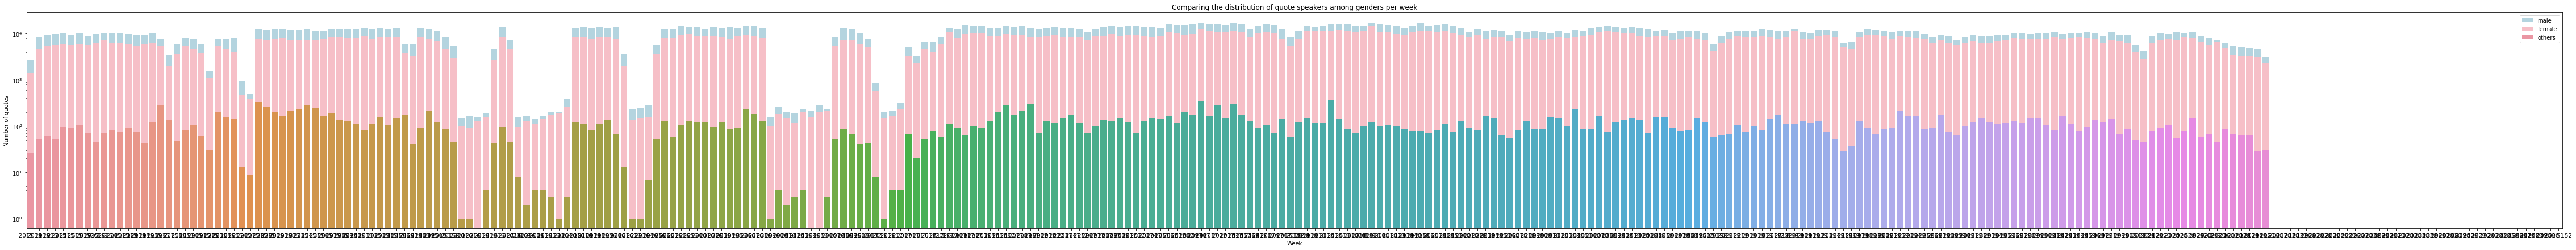

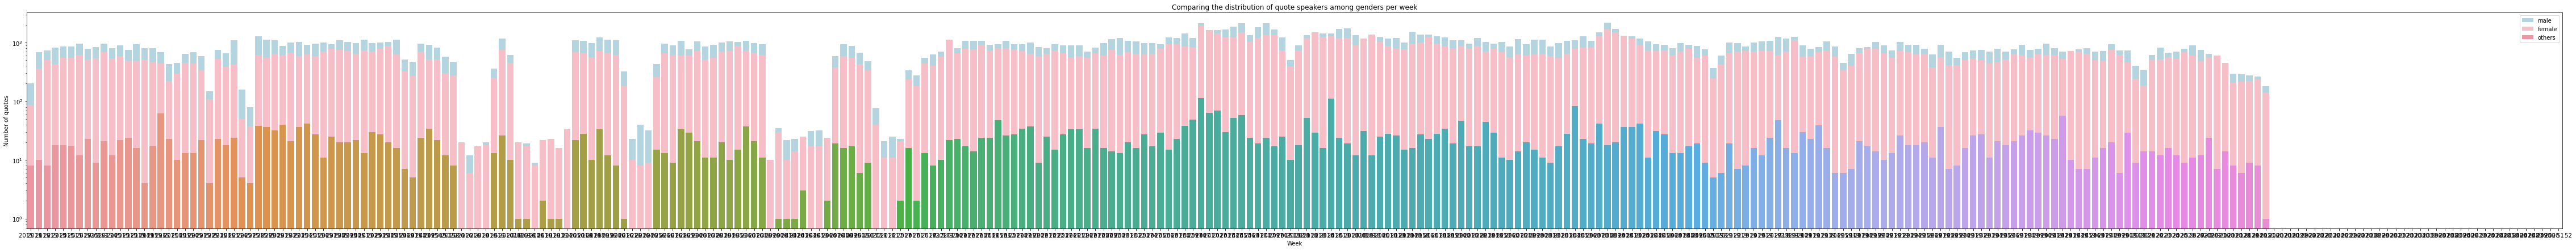

In [31]:
years = range(2015, 2020+1)

data_paths = [path_quote_women, path_quote_metoo]
for data_path in data_paths:
    data_path = data_path[:-9] + '_weekly_count' + data_path[-9:]
    count_paths = [data_path.format(year) for year in years]
    df_counts = []
    for path in count_paths:
        df_counts.append(pd.read_json(path, lines=True).iloc[:-1].set_index('week'))

    df_all = pd.DataFrame()
    week53 = pd.DataFrame(0, index=['0'], columns=df_all.columns)
    week53 = [0]*df_counts[0].shape[1]
    for df, year in zip(df_counts, years):
        df.iloc[0] = [sum(x) for x in zip(df.iloc[0], week53)]
        week53 = df.iloc[-1]
        df['year'] = year
        df['week'] = df.index
        df['idx'] = str(year) + ' - ' + df.index.astype(str)
        df_all = df_all.append(df.iloc[:-1]) # lost week 53 of last year (but as it ends at week 16: OK)
    df_plot = df_all.copy().set_index('idx')
    df_all.set_index(['week', 'year'] ,inplace=True)

    # PLOT
    ax = sns.barplot(x=df_plot.index, y=df_plot.male,   label='male',   color='lightblue')
    ax = sns.barplot(x=df_plot.index, y=df_plot.female, label='female', color='lightpink')
    ax = sns.barplot(x=df_plot.index, y=df_plot.others, label='others' )
    plt.yscale('log')

    #ax.axvlines(x=df_plot.index[7]) # want to add vertival line btwn years

    plt.xlabel('Week')
    plt.ylabel('Number of quotes')
    plt.title('Comparing the distribution of quote speakers among genders per week')
    plt.legend()
    plt.rcParams['figure.figsize'] = (80,7)
    plt.show()

    
### CHECK DATA

In [14]:
year = 2017
pd.read_json(PATH_DATA + f'Quotebank/metoo/quotes-{year}-filtered_metoo/{year}_others.json.bz2', lines=True)

,quoteID,quotation,speaker,date,week,month,qid,date_of_birth,gender,party,id
0,2017-08-23-110525,Some [ but not all ] of the testosterone-fuell...,Sam Smith,2017-08-23 06:01:01,34,8,Q15123969,[+1992-05-19T00:00:00Z],Q48270,None,Q15123969
1,2017-10-12-041735,I actually don't think I'm the first ever tran...,Georgina Beyer,2017-10-12 17:44:55,41,10,Q466137,[+1957-11-00T00:00:00Z],Q1052281,[Q1048192],Q466137
2,2017-06-15-132509,Trans employees are still absolutely covered b...,Mara Keisling,2017-06-15 17:15:47,24,6,Q6754500,[+1959-09-29T00:00:00Z],Q1052281,None,Q6754500
3,2017-10-20-053374,I told the head of your studio [ Roy Price ] t...,Rose McGowan,2017-10-20 10:38:50,42,10,Q211040,[+1973-09-05T00:00:00Z],Q48270,None,Q211040
4,2017-10-12-153683,told the head of your studio that HW raped me.,Rose McGowan,2017-10-12 00:00:00,41,10,Q211040,[+1973-09-05T00:00:00Z],Q48270,None,Q211040
...,...,...,...,...,...,...,...,...,...,...,...
1315,2017-04-07-161227,"With this historic decision, the 7th Circuit i...",Shannon Minter,2017-04-07 02:42:20,14,4,Q7488917,[+1961-02-14T00:00:00Z],Q2449503,None,Q7488917
1316,2017-06-01-136804,This woman has to look at her conscience and l...,Cate McGregor,2017-06-01 10:15:00,22,6,Q16201513,[+1956-00-00T00:00:00Z],Q1052281,None,Q16201513
1317,2017-11-13-084203,petition called for the cancellation of my lec...,Judith Butler,2017-11-13 08:00:00,46,11,Q219368,[+1956-02-24T00:00:00Z],Q48270,None,Q219368
1318,2017-09-28-176898,"You can change your appearances, but your DNA ...",Danica Roem,2017-09-28 00:00:00,39,9,Q30323707,[+1984-09-30T00:00:00Z],Q1052281,[Q29552],Q30323707


### results control

In [241]:
# index of the chosen person that will be described
chosen_one = 23

# gender is male
chosen_male = df_parquet[df_parquet.id.isin(speaker_male.iloc[chosen_one])]
male_desc = df_qid[df_qid.QID == chosen_male.gender.values[0][0]]
print(male_desc,'\n')
print(f'number of male speaker : {speaker_male.shape[0]}',
      f'their quotes           : {df_count.iloc[-1].male}',
      f'approx {(df_count.iloc[-1].male/speaker_male.shape[0]):.2f} quotes per person', sep='\n')
chosen_male

           QID Label                                        Description
2504  Q6581097  male  to be used in "sex or gender" (P21) to indicat... 

number of male speaker : 46131
their quotes           : 103892
approx 2.25 quotes per person


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3710882,None,None,None,[Q6581097],1376790398,None,None,None,None,None,Q16734497,Ted Phillips,None,item,None


In [242]:
# gender is female
chosen_female = df_parquet[df_parquet.id.isin(speaker_female.iloc[chosen_one])]
female_desc = df_qid[df_qid.QID == chosen_female.gender.values[0][0]]
print(female_desc,'\n')
print(f'number of female speaker : {speaker_female.shape[0]}',
      f'their quotes             : {df_count.iloc[-1].female}',
      f'approx {(df_count.iloc[-1].female/speaker_female.shape[0]):.2f} quotes per person', sep='\n')
chosen_female

           QID   Label                                        Description
7145  Q6581072  female  to be used in "sex or gender" (P21) to indicat... 

number of female speaker : 11889
their quotes             : 23833
approx 2.00 quotes per person


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3772621,None,[+1984-07-30T00:00:00Z],[Q717],[Q6581072],1372307274,None,None,"[Q33999, Q4610556]",None,None,Q21558740,Patricia Ramos,None,item,None


In [243]:
# gender is others
chosen_other = df_parquet[df_parquet.id.isin(speaker_others.iloc[chosen_one])]
other_desc = df_qid[df_qid.QID == chosen_other.gender.values[0][0]]
print(other_desc,'\n')
print(df_count.loc['sum'].others)
print(f'number of others speaker: {speaker_others.shape[0]}',
      f'their quotes            : {df_count.iloc[-1].others}',
      f'approx {(df_count.iloc[-1].others/speaker_others.shape[0]):.2f} quotes per person', sep='\n')
chosen_other

          QID       Label                                        Description
18845  Q48270  non-binary  range of gender identities that are not exclus... 

239
number of others speaker: 115
their quotes            : 239
approx 2.08 quotes per person


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
6248852,"[Dominique McLean, SonicFox5000]",[+1998-03-02T00:00:00Z],[Q30],[Q48270],1378527453,[Q49085],None,[Q4379701],None,None,Q59542692,SonicFox,None,item,None


In [244]:
# gender is none
chosen_none = df_parquet[df_parquet.id.isin(speaker_noInfo.iloc[chosen_one])]
print(f'number of None speaker: {speaker_noInfo.shape[0]}',
      f'their quotes          : {df_count.iloc[-1].noInfo}',
      f'approx {(df_count.iloc[-1].noInfo/speaker_noInfo.shape[0]):.2f} quotes per person', sep='\n')
chosen_none

number of None speaker: 1193
their quotes          : 1477
approx 1.24 quotes per person


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
562906,None,None,None,None,1194325643,None,None,[Q1650915],None,None,Q56808283,Courtney Price,None,item,None


In [269]:
# epmpty dataframe | do we catch them online ?
chosen_ko = df_parquet[df_parquet.id.isin(speaker_noMeta.iloc[chosen_one])]
print(f'number of speaker not repertoried: {speaker_noMeta.shape[0]}')
speaker_noMeta_labeled = df_qid[df_qid.QID == speaker_noMeta.iloc[chosen_one].qids]
chosen_ko

# are some of thespeaker that are not defined in parquet defined in label ? NO
# CODE

number of speaker not repertoried: 484


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion


In [246]:
# find a speaker according to gender in df_gender_firstSpeaker
# Certainly need to select other than the first gender -> adapt other_desc (2nd index)
chosen_gender_idx = 20 # MAX value : 38
chosen = df_parquet[df_parquet.id == df_gender_firstSpeaker.speaker_qids[chosen_gender_idx]]
other_desc = df_qid[df_qid.QID == chosen.gender.values[0][0]] # second index is 1 bc its second gender is not labeled
print('should be:', df_gender_firstSpeaker.index[chosen_gender_idx].upper())
print(other_desc,'\n')
chosen

should be: INTERSEX
           QID   Label                                        Description
7145  Q6581072  female  to be used in "sex or gender" (P21) to indicat... 



,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
2175,None,[+1986-07-06T00:00:00Z],[Q183],"[Q6581072, Q1097630]",1390189942,None,None,[Q10833314],None,None,Q72636,Sarah Gronert,None,item,None


**Note:** there are 0 wrong genders which might seem strange since we said that Quotebank contained those. But this also could be expected, because when considering only the first gender in the QID's array, the less important genders are dropped.

*Example:* Consider an imaginary quote from Samurai Jack, we would get as genders `['male', 'samurai']` but our code only takes into account `'male'`

---

***Results of previous 2 cells***

In [ ]:
# Write result in CSV file
df_count.to_csv(PATH_DATA_OUT + f'{year}_count.csv')
speaker_noMeta.to_csv(PATH_DATA_OUT + f'{year}_missing_meta.csv')

There aren't any quotes after week 16. This comes from the fact that the Quotebank dataset stopped analysing quotes until April 2020 (see [Quotebank paper](https://dlab.epfl.ch/people/west/pub/Vaucher-Spitz-Catasta-West_WSDM-21.pdf)). This is not the case for previous years as we have seen in our analysis, or as the TA's might see if they decide to run our notebook with the full years `[2015;2020]`

We also can output that the last month was april from the following code which would take ~5 mins to complete
```python
df_20 = pd.read_json(PATH_DATA+FILE_20, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
max_month = -1
for chunk in df_20:
    chunk['month'] = get_month(chunk, 'quoteID').astype(int)
    month = chunk.month.max()
    if month>max_month:
        max_month = month

print(f'max month in 2020 is: {max_month}')
```
> out: max month in 2020 is: 4

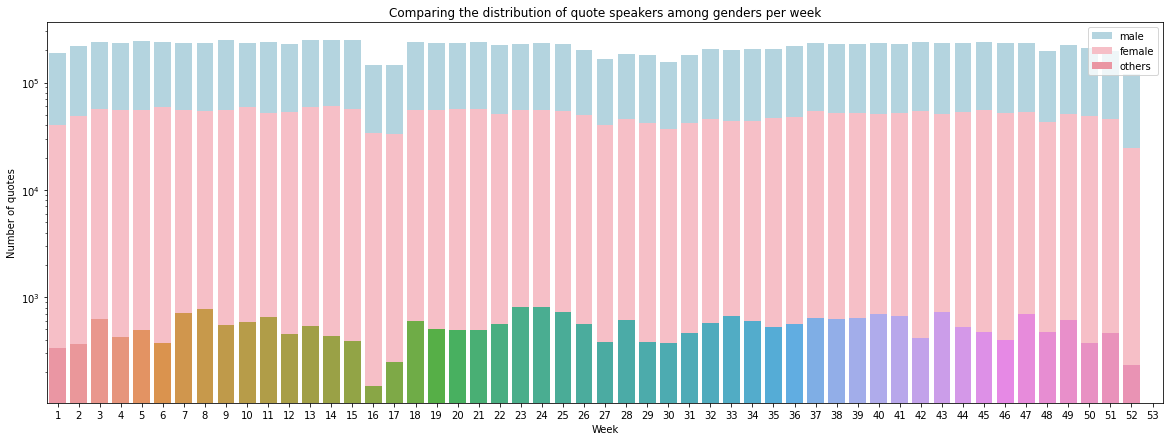

In [77]:
last_row = -1 # the last row is the sum -> plotted separately
if year == 2020:
    last_row = 16 # year 2020 ends in april (available data only first 16 week of the year)

sns.barplot(x=df_count.index[:last_row],y=df_count['male'].iloc[:last_row], color='lightblue', label='male')
sns.barplot(x=df_count.index[:last_row],y=df_count['female'].iloc[:last_row], color='lightpink', label='female')
sns.barplot(x=df_count.index[:last_row],y=df_count['others'].iloc[:last_row], label='others')
plt.yscale('log')

plt.xlabel('Week')
plt.ylabel('Number of quotes')
plt.title('Comparing the distribution of quote speakers among genders per week')
plt.legend()
plt.rcParams['figure.figsize'] = (20,7)
plt.show()

On this logarithmic-scale plot, we can clearly see the difference in the importance of each gender in media. The distribution of men and women speakers through time is roughly the same (see correlation below). However, for LGBT+ (other) speakers, they are rarer and seem to speak in peaks which might be correlated with events that happened that week.

In [24]:
print('Correlation : (Pearson correlation coefficient, p-value)')
print(f'Male/Female : {stats.pearsonr(df_count.iloc[:16]["male"], df_count.iloc[:16]["female"])}')
print(f'LGBT+/Total : {stats.pearsonr(df_count.iloc[:16]["others"], df_count.iloc[:16]["all"])}') # Lower correlation due to rarer data

Correlation : (Pearson correlation coefficient, p-value)
Male/Female : (0.9863442003930507, 2.2905848236518718e-12)
LGBT+/Total : (0.6518193884509832, 0.006220202646455371)


---

## Irregularities in data

### 1. Speaker not repertiored:
get speaker QID from \[speaker_noMeta\] and input it in \[df_parquet\] as follow:
``` python
i = 0
df_parquet[df_parquet.id == speaker_noMeta.iloc[i].values[0]]
```
> should return an empty DataFrame

Example:

i = 0 : [Q59209387](https://www.wikidata.org/wiki/Q59209387) does not exist\
i = 1 : [Q30337200](https://www.wikidata.org/wiki/Q30337200) Philippe Bouyer 

### 2. Gender not described:
*See first two rows of output of this [cell](#error1)*
If the link does not work, it is the output of python cell number 13.

### 3. Gender is not a real gender
*See explanation in this [cell](#error2)*
If the link does not work, it is the explanation under python cell number 13.

In [26]:
# Error to stop compilation of notebook:
EndError

NameError: name 'EndError' is not defined

<a id='all_weeks'></a>
# reload saved results

In [35]:
years = range(2015, 2021)
counts = [PATH_DATA_RESULT + f'{year}_count.csv' for year in years]
df_counts = []
for count in counts:
    df_counts.append(pd.read_csv(count, index_col='Unnamed: 0'))

df_all = pd.DataFrame()
week53 = pd.DataFrame()
for df, year in zip(df_counts, years):
    df = df.drop('sum')
    df.iloc[0:1] = df.iloc[0:1].add(week53, fill_value=0)
    week53 = df.iloc[-1:]
    df['year'] = year
    df['week'] = df.index.astype(int)
    df['idx'] = str(year) + ' - ' +df.index
    df_all = df_all.append(df.iloc[:-1]) # lost week 53 of last year (but as it ends at week 16: OK)
df_plot = df_all.copy().set_index('idx')
df_all = df_all.drop(columns='idx')
df_all = df_all.set_index(['year', 'week'])
df_all

male   female  others  wrong  noInfo  noMeta   unknown  \
year week                                                               
2015 1      67089.0   9736.0   123.0    0.0   576.0   319.0   39696.0   
     2     200940.0  32726.0   327.0    0.0  2296.0  1250.0  121896.0   
     3     220085.0  38426.0   430.0    0.0  2319.0  1572.0  135815.0   
     4     223480.0  40393.0   371.0    0.0  2409.0  1627.0  137456.0   
     5     229602.0  41393.0   476.0    0.0  2546.0  1491.0  140813.0   
...             ...      ...     ...    ...     ...     ...       ...   
2020 48         0.0      0.0     0.0    0.0     0.0     0.0       0.0   
     49         0.0      0.0     0.0    0.0     0.0     0.0       0.0   
     50         0.0      0.0     0.0    0.0     0.0     0.0       0.0   
     51         0.0      0.0     0.0    0.0     0.0     0.0       0.0   
     52         0.0      0.0     0.0    0.0     0.0     0.0       0.0   

                all  
year week            
2015 1     117539.0  
     2     359435.0  
     3     398647.0  
     4     405736.0  
     5     416321.0  
...             ...  
2020 48         0.0  
     49         0.0  
     50         0.0  
     51         0.0  
     52         0.0  

[312 rows x 8 columns]

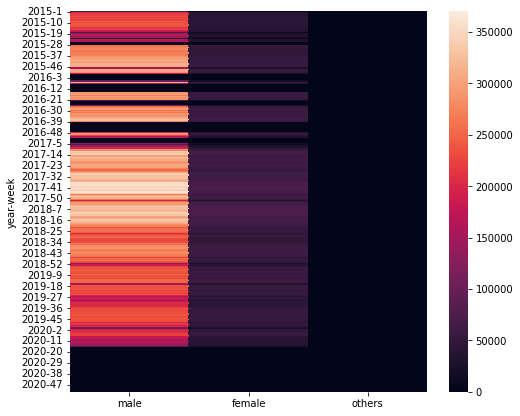

In [41]:
sns.heatmap(df_all[['male', 'female', 'others']])

### graph
> I don't know why but next cell need to be run **twice**

In [12]:
%%time


ax = sns.barplot(x=df_plot.index,y=df_plot.others+df_plot.female+df_plot.male, color='black', label='others')
ax = sns.barplot(x=df_plot.index,y=df_plot.male, color='lightblue', label='male')
ax = sns.barplot(x=df_plot.index,y=df_plot.female, color='lightpink', label='female')
ax = sns.barplot(x=df_plot.index,y=df_plot.others, label='others')
plt.yscale('log')

#ax.axvlines(x=df_plot.index[7]) # want to add vertival line btwn years

plt.xlabel('Week')
plt.ylabel('Number of quotes')
plt.title('Comparing the distribution of quote speakers among genders per week')
plt.legend()

In [13]:
plt.rcParams['figure.figsize'] = (8,7)
plt.show()

**NOTE:** As already mentioned, this is only the output for the year 2020.

We have run the parsing code for every year in `[2015;2020]` and we got the following results:

Year | Original Size | Filtered Size | Pickle Size | Time to filter |
:---:|:-------------:|:-------------:|:-----------:|:--------------:|
2020 |792.3 MB       |59.7 MB        |55 MB        |6 min 47s       |
2019 |3.32 GB        |345.4 MB       |318.2 MB     |39 min 5s       |
2018 |4.48 GB        |462.6 MB       |425.8 MB     |52 min 14s      |
2017 |4.84 GB        |447.6 MB       |411.2 MB     |50 min 30s      |
2016 |2.16 GB        |210.1 MB       |193.1 MB     |23 min 42s      |
2015 |3.11 GB        |293 MB         |269.2 MB     |33 min 1s       |
Total|18.7 GB        |1.82 GB        |1.67 GB      |3h 25 min 19s   |

*N.B: file sizes correspond to the .bz2 compressed files and they depend on the compression algorithm in each OS*

We can see that dataset D3 is approximately 10 times smaller than the whole Quotebank, which focuses more towards answering our questions. We can also expect to miss a lot of quotes mentioning women, as well as take in D3 quote that do not mention women seeing that we are just taking the quotes mentioning them explicitely through our defined dictionary. But this is still enough for us to conduct our observations.

The creation of the pickle files is a way to load the data faster for later uses. The size of the data makes its handling take time in the order of hours which would be much more decreased when loading from pickle files, which reduces waiting time by a factor of ~9.

---

## What Next?

*What follow is a more detailed explanation of the __Methods__ paragraph in the __README__*.

* **Step 1: Data scraping, pre-processing and dataset construction.**\
  This is what has been run in the notebook

* **Step 2: General preliminary analysis using Quotebank entire dataset.**\
  In this step, we will plot the weekly percentage of quotes by author’s gender (men, women, other, unknown) from 2015 to 2020. This will allow us to have a general perspective on the place that women are being given in the mediatic place through time.
  With our result, we will see if the place given to woman, in terms of weekly percentage of speaker, correlates with the #MeToo movement important dates.

* **Step 3: Generate annual word clouds based on dataset D1.**
  From this, it would be interesting to use dataset D1 (containing all the quotes from women authors) to make a deeper analysis on the women’s quotes. By creating annual or 6-monthly word clouds, we would like to identify the main topics discussed by women in these quotes through time. ([Library possibly used](https://github.com/amueller/word_cloud))

* **Step 4: Investigate gender, political and generational biases in MeToo coverage using NLP to answer question A) with dataset D2.**\
  In this part, we will try to answer question A). For this, we will use dataset D2 and its subsets D2.1, D2.2 and D2.3, and we will train an NLP model (e.g. [spacy](https://spacy.io/usage/training)) with dataset AD3 to perform sentiment analysis on them. We will then perform a classification thanks to the trained NLP model on the whole dataset D2. By then subdividing D2 into D2.1, D2.2 and D2.3, we will perform the following analysis:
  1. **Investigate the gender biases:**\
    Plotting the percentages of men and women’s quotes in D2 and comparing them with the result obtained in step 1. We will see therefore if the way women are given voices differs talking about MeToo or in general.
    Thanks to the sentiment analysis previously performed, we will be able to identify any difference in tone between the gender by plotting distributions and visualizing the classes for quotes of each gender.
    We will generate word clouds for quotes of each gender to get a sense of the words most used when talking about MeToo depending on the gender.

  2. **Investigate political biases:**\
    Plotting the percentage of quotes in D2 for the different political parties.
    Thanks to the sentiment analysis previously performed, we will be able to identify any difference in tone between the political parties by plotting distributions and visualizing the classes for quotes of each party.
    We will generate word clouds for quotes of each political party to get a sense of the words most used when talking about MeToo depending on the gender.

  3. **Investigate generational biases:**\
    Plotting the percentage of quotes in D2 for the different age groups
    Thanks to the sentiment analysis previously performed, we will be able to identify any difference in tone between the age groups by plotting distributions and visualizing the classes for quotes of each group.
    We will generate word clouds for quotes of each age group to get a sense of the words most used when talking about MeToo depending on the age and gender.

  4. **Inherent biases in the structure of dataset D2:**\
    Various clustering trials with unsupervised different ML algorithms applied on the sentiment analysis classification probabilities returned previously. This aims at revealing clusters and therefore biases inherent to the data.

* **Step 5: Investigate general women perception via quotes mentioning women (dataset D3) in media to answer question B).**\
  This step aims to answer the question of the general perception of women in the media. We will investigate this problematic by using two different classifying NLP models applied to D3.
  Generate 6-monthly word clouds.
  Text Blob or Vader models for classifying the quotes as positive, negative or neutral. These NLP models return probabilities for the tone to be positive or negative. Probabilities thresholds will have to be set to determine the class boundaries.
  We will then train the SpaCy model on AD2 for classifying the quotes as misogynistic or non misogynistic. The trained model will then be used to classify the quotes of D3. Finally, we will plot the distributions of quote classes with respect to time.

* **Step 6: Correlate and investigate causation between MeToo general perception and women’s mediatic place to answer question C).**\
  This last step aims at answering if the evolution of women’s mediatization is correlated and has been tuned by the tendencies of MeToo’s mediatic perspective. To that end, we will make timelines, plot the data distributions and information previously collected, according to time, and compare them to major turning points and mediatization phases of the MeToo movement. We will investigate the statistical significance of the detected changes, variations of women’s mediatic place and mediatization before and after MeToo, thanks to adapted statistical tests.

* **Step 7: Github site building and Datastory redaction.**\
  MeToo movement timeline that will be useful for the Datastory and Data Analysis:
  In order to correlate our analysis with the key turning points and dates of the MeToo movement, we will use week bins, week timespans.
  This non-exhaustive list can be further completed thanks to the dates and key turning points of the MeToo movement, thanks to the data available on [this webpage.](https://www.refinery29.com/en-us/2018/10/212801/me-too-movement-history-timeline-year-weinstein)
